In [9]:
'''Import basic libraries'''
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os 
#Import dengue datafile
dengue = pd.read_csv("C:/Users/Patrick/Downloads/Dengue_Daily.csv")

Script to Clean Up Data 

In [10]:
#Checking shape of dengue file
print(dengue.shape)
#Drop imported cases and reset index
dengue_local = dengue[dengue['是否境外移入']=='否'].reset_index(drop=True)
#Checking shape of local dengue cases
print(dengue_local.shape)


(107248, 26)
(102296, 26)


In [11]:
'''Import CSV Files of Basic Statistics Area and their Population'''

# Directory containing the nested folders
base_dir = "D:/Projects/TMU/BSA_population_TN"

# Walk through the directory to find all CSV files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".csv"):
            # Extract the first number from the filename
            number = int(''.join(filter(str.isdigit, file.split("年")[0])))  # Get the number before '年'
            year = number + 1911  # Add 1911
            
            # Full path to the CSV file
            file_path = os.path.join(root, file)
            
            # Attempt to load the CSV file with both encodings
            for encoding in ["utf-8", "big5"]:
                try:
                    df_name = f"df_{year}"
                    globals()[df_name] = pd.read_csv(file_path, encoding=encoding)
                    print(f"Successfully loaded {file} as {df_name} using {encoding} encoding.")
                    break  # Exit the loop if successfully loaded
                except Exception as e:
                    print(f"Failed to load {file} with {encoding} encoding. Error: {e}")

Failed to load 104年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 104年12月臺南市統計區人口統計_最小統計區.csv as df_2015 using big5 encoding.
Failed to load 105年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 105年12月臺南市統計區人口統計_最小統計區.csv as df_2016 using big5 encoding.
Successfully loaded 106年12月臺南市統計區人口統計_最小統計區.csv as df_2017 using utf-8 encoding.
Failed to load 107年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 107年12月臺南市統計區人口統計_最小統計區.csv as df_2018 using big5 encoding.
Failed to load 108年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 108年12月臺南市統計區人口統計_最小統計區.csv as df_2019 using big5 encoding.
Failed to load 109年12月臺南市統計區人口統

In [12]:
'''Cleaning up data from BSA population and dengue incidence data'''
# Convert all dates in Dengue Data to Datetime Object
dengue_local['發病日'] = pd.to_datetime(dengue_local['發病日'], format='%Y/%m/%d')
dengue_local['Year'] = dengue_local['發病日'].dt.year


In [13]:
# Define districts that are acccounted for
allowed_districts = ['東區', '安南區', '南區', '北區', '中西區', '安平區']
# Read in Taiwan shapefile
tn_shp = gpd.read_file('C:/Users/Patrick/Downloads/0-67000/G97_67000_U0200_2015.shp')
# Filter SHP file by Area
filtered_tn_shp = tn_shp[tn_shp['TOWN'].isin(allowed_districts)]
# Filter Dengue Cases by Tainan
tn_dengue = dengue_local[dengue_local['居住縣市']=='台南市'].reset_index(drop=True)
# Filter Tainan Dengue Cases by Area
filtered_tn_dengue = tn_dengue[
    (tn_dengue['居住鄉鎮'].isin(allowed_districts)) &
    (tn_dengue['Year'] >= 2015) &
    (tn_dengue['Year'] <= 2023) 
].reset_index(drop=True)
# Rename column of BSA Serial Number
filtered_tn_dengue = filtered_tn_dengue.rename(columns={"最小統計區":'CODEBASE'})


In [14]:
# Check how many infections happen in the Tainan Urban Area
filtered_tn_dengue['Year'].value_counts()

2015    18650
2023    15453
2019       26
2016        4
2018        1
Name: Year, dtype: int64

Script to calculate incidence rate for the significant years.

In [27]:
# Tallying dengue infections by year and CODEBASE
dengue_2015 = filtered_tn_dengue[filtered_tn_dengue['Year'] == 2015].groupby('CODEBASE').size().reset_index(name='Infections_2015')
dengue_2019 = filtered_tn_dengue[filtered_tn_dengue['Year'] == 2019].groupby('CODEBASE').size().reset_index(name='Infections_2019')
dengue_2023 = filtered_tn_dengue[filtered_tn_dengue['Year'] == 2023].groupby('CODEBASE').size().reset_index(name='Infections_2023')

# Merging population data with infection counts for each year
df_2015_pop = df_2015[['CODEBASE', 'P_CNT']].rename(columns={'P_CNT': 'Population_2015'})
df_2019_pop = df_2019[['CODEBASE', 'P_CNT']].rename(columns={'P_CNT': 'Population_2019'})
df_2023_pop = df_2023[['CODEBASE', 'P_CNT']].rename(columns={'P_CNT': 'Population_2023'})

# Merging infection data with population data for each year
df_2015_incidence = pd.merge(dengue_2015, df_2015_pop, on='CODEBASE', how='left')
df_2019_incidence = pd.merge(dengue_2019, df_2019_pop, on='CODEBASE', how='left')
df_2023_incidence = pd.merge(dengue_2023, df_2023_pop, on='CODEBASE', how='left')


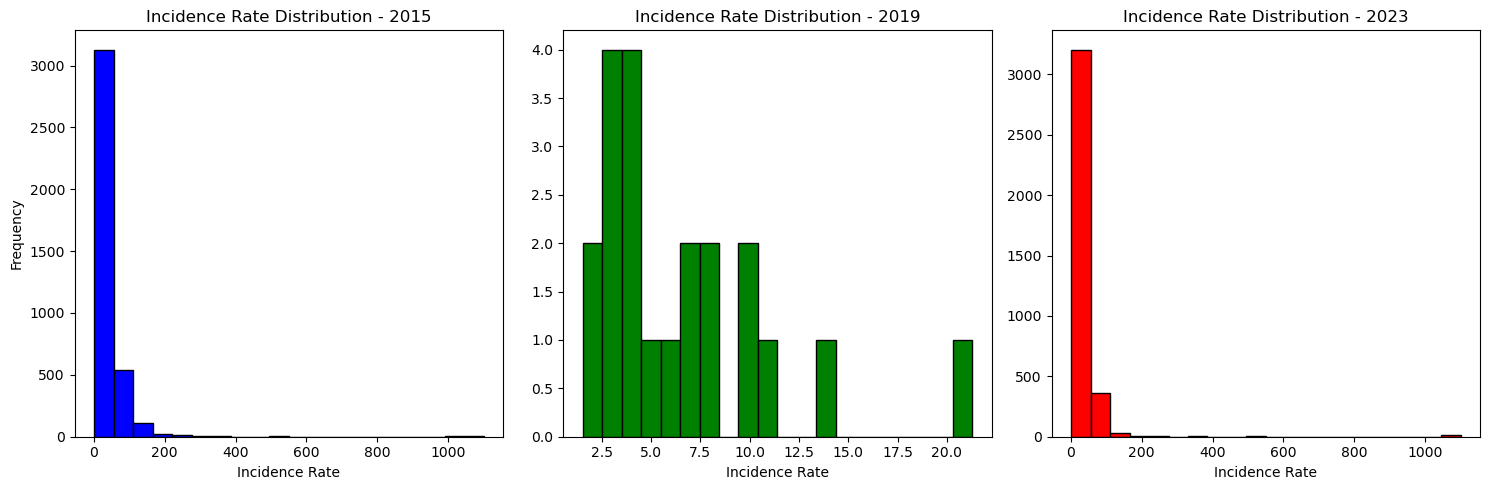

In [107]:
# Ensure all infection and population columns are numeric
df_2015_incidence['Infections_2015'] = pd.to_numeric(df_2015_incidence['Infections_2015'], errors='coerce')
df_2015_incidence['Population_2015'] = pd.to_numeric(df_2015_incidence['Population_2015'], errors='coerce')

df_2019_incidence['Infections_2019'] = pd.to_numeric(df_2019_incidence['Infections_2019'], errors='coerce')
df_2019_incidence['Population_2019'] = pd.to_numeric(df_2019_incidence['Population_2019'], errors='coerce')

df_2023_incidence['Infections_2023'] = pd.to_numeric(df_2023_incidence['Infections_2023'], errors='coerce')
df_2023_incidence['Population_2023'] = pd.to_numeric(df_2023_incidence['Population_2023'], errors='coerce')

# Now calculate the incidence rates
df_2015_incidence['Incidence_Rate_2015'] = (df_2015_incidence['Infections_2015'] / df_2015_incidence['Population_2015']) * 1000
df_2019_incidence['Incidence_Rate_2019'] = (df_2019_incidence['Infections_2019'] / df_2019_incidence['Population_2019']) * 1000
df_2023_incidence['Incidence_Rate_2023'] = (df_2023_incidence['Infections_2023'] / df_2023_incidence['Population_2023']) * 1000

import matplotlib.pyplot as plt

# Set incidence rates over 1000 to 1100
df_2015_incidence.loc[df_2015_incidence['Incidence_Rate_2015'] > 1000, 'Incidence_Rate_2015'] = 1100
df_2019_incidence.loc[df_2019_incidence['Incidence_Rate_2019'] > 1000, 'Incidence_Rate_2019'] = 1100
df_2023_incidence.loc[df_2023_incidence['Incidence_Rate_2023'] > 1000, 'Incidence_Rate_2023'] = 1100

# Create histograms for incidence rate distribution
plt.figure(figsize=(15, 5))

# Histogram for 2015
plt.subplot(1, 3, 1)
plt.hist(df_2015_incidence['Incidence_Rate_2015'], bins=20, color='blue', edgecolor='black')
plt.title('Incidence Rate Distribution - 2015')
plt.xlabel('Incidence Rate')
plt.ylabel('Frequency')

# Histogram for 2019
plt.subplot(1, 3, 2)
plt.hist(df_2019_incidence['Incidence_Rate_2019'], bins=20, color='green', edgecolor='black')
plt.title('Incidence Rate Distribution - 2019')
plt.xlabel('Incidence Rate')

# Histogram for 2023
plt.subplot(1, 3, 3)
plt.hist(df_2023_incidence['Incidence_Rate_2023'], bins=20, color='red', edgecolor='black')
plt.title('Incidence Rate Distribution - 2023')
plt.xlabel('Incidence Rate')

# Show the plots
plt.tight_layout()
plt.show()

In [105]:
# Merging the incidence rate data with the shapefile data
merged_2015 = pd.merge(filtered_tn_shp, df_2015_incidence[['CODEBASE', 'Incidence_Rate_2015']], on='CODEBASE', how='left')
merged_2019 = pd.merge(filtered_tn_shp, df_2019_incidence[['CODEBASE', 'Incidence_Rate_2019']], on='CODEBASE', how='left')
merged_2023 = pd.merge(filtered_tn_shp, df_2023_incidence[['CODEBASE', 'Incidence_Rate_2023']], on='CODEBASE', how='left')


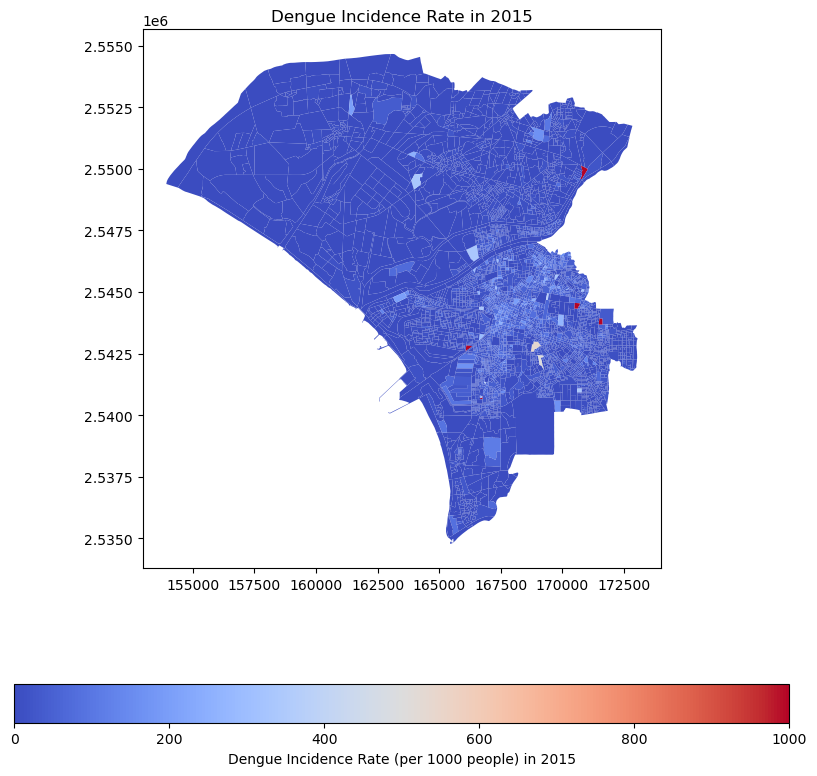

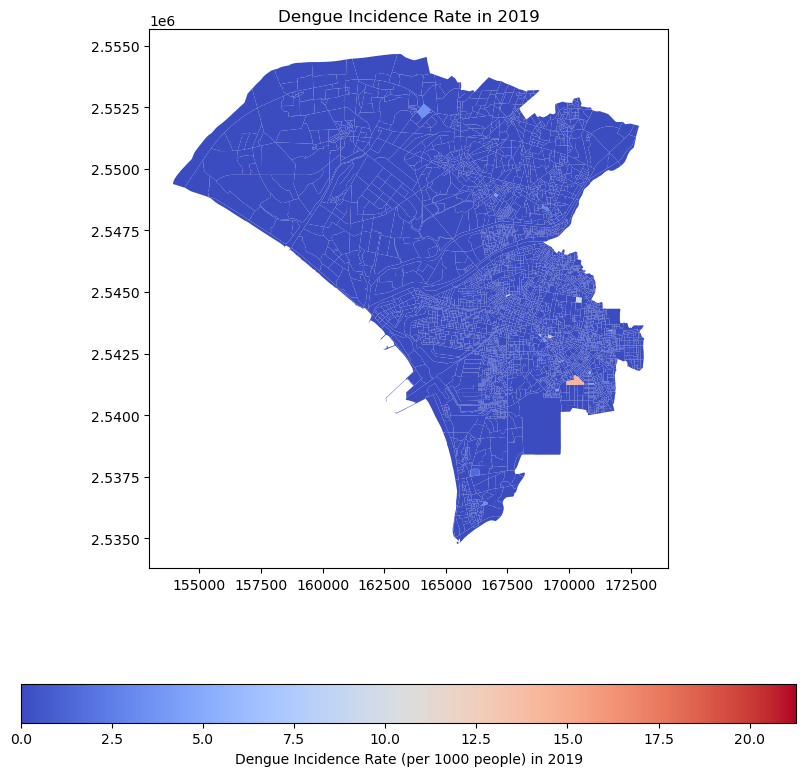

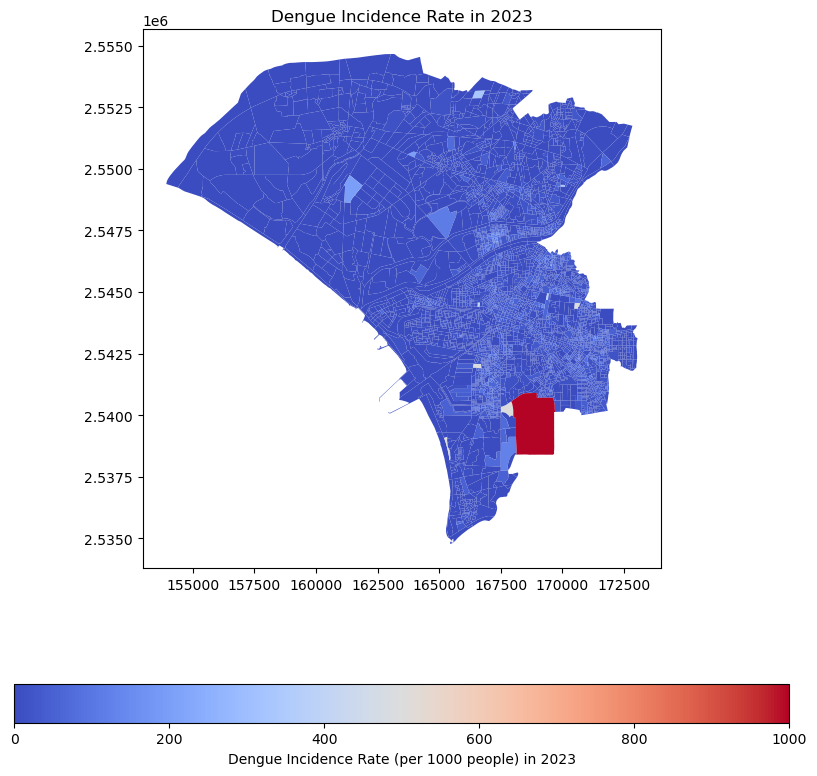

In [106]:
# Fill missing values with a default value (e.g., 0 or -1, or use NaN for no data)
merged_2015['Incidence_Rate_2015'].fillna(0, inplace=True)  # Fill NaNs with 0 (or you can use np.nan)
merged_2019['Incidence_Rate_2019'].fillna(0, inplace=True)
merged_2023['Incidence_Rate_2023'].fillna(0, inplace=True)

# Plotting the choropleth map for 2015
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_2015.plot(column='Incidence_Rate_2015', ax=ax, legend=True,
                 legend_kwds={'label': "Dengue Incidence Rate (per 1000 people) in 2015",
                              'orientation': "horizontal"},
                 cmap='coolwarm',  # You can choose a different colormap
                 missing_kwds={'color': 'gray'})  # This sets the color for missing data
ax.set_title("Dengue Incidence Rate in 2015")
plt.show()

# Plotting the choropleth map for 2019
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_2019.plot(column='Incidence_Rate_2019', ax=ax, legend=True,
                 legend_kwds={'label': "Dengue Incidence Rate (per 1000 people) in 2019",
                              'orientation': "horizontal"},
                 cmap='coolwarm',
                 missing_kwds={'color': 'gray'})  # This sets the color for missing data
ax.set_title("Dengue Incidence Rate in 2019")
plt.show()

# Plotting the choropleth map for 2023
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_2023.plot(column='Incidence_Rate_2023', ax=ax, legend=True,
                 legend_kwds={'label': "Dengue Incidence Rate (per 1000 people) in 2023",
                              'orientation': "horizontal"},
                 cmap='coolwarm',
                 missing_kwds={'color': 'gray'})  # This sets the color for missing data
ax.set_title("Dengue Incidence Rate in 2023")
plt.show()

Script to create time series plots of weekly aggregated new infections.

In [114]:
years_to_plot = [2015, 2019, 2023]
output_directory = "D:/Projects/TMU/Dengue"
os.makedirs(output_directory, exist_ok=True)

# Function to generate weekly aggregated plot for a given year
def plot_weekly_aggregated_counts(df, year, output_dir):
    df_year = df[df['Year'] == year]
    df_year['Week'] = df_year['發病日'].dt.isocalendar().week
    
    weekly_counts = df_year.groupby('Week').size()
    
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_counts.index, weekly_counts.values, marker='o')
    plt.title(f'Weekly Dengue Cases - {year}')
    plt.xlabel('Week Number')
    plt.ylabel('Number of Cases')
    plt.grid(True)
    
    output_path = os.path.join(output_dir, f'dengue_weekly_{year}.png')
    plt.savefig(output_path)
    plt.close()
    return output_path

plot_weekly_aggregated_counts(filtered_tn_dengue, 2015, output_directory)
plot_weekly_aggregated_counts(filtered_tn_dengue, 2019, output_directory)
plot_weekly_aggregated_counts(filtered_tn_dengue, 2023, output_directory)


C:\Users\Patrick\AppData\Local\Temp\ipykernel_6396\2527858560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Week'] = df_year['發病日'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_6396\2527858560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Week'] = df_year['發病日'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_6396\2527858560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

'D:/Projects/TMU/Dengue\\dengue_weekly_2023.png'